# Week5 - Lab

* Assign X, y
* Train-test split
* Visualize & speculate on training dataset
* Train a logistic regression model
* Evaluate the model, roc score
* Explain findings

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.preprocessing import PolynomialFeatures


# https://www.kaggle.com/datasets/muhammadtalharasool/simple-gender-classification?select=gender.csv
df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/log_reg/gender.csv').iloc[:,:-1]
df.columns = df.columns.str.strip()
df.Gender = df.Gender.str.strip()

<AxesSubplot:>

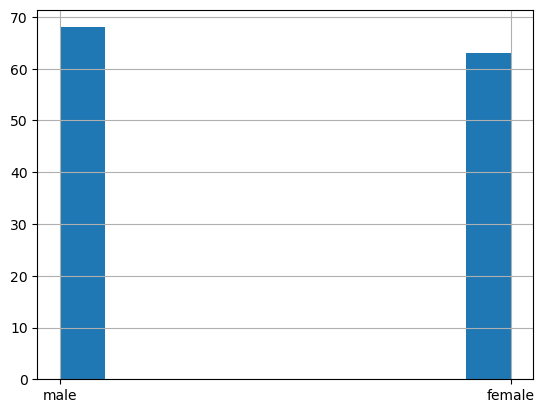

In [50]:
df.Gender.hist()

In [51]:
df.head()

,Gender,Age,Height (cm),Weight (kg),Occupation,Education Level,Marital Status,Income (USD),Favorite Color
0,male,32,175,70,Software Engineer,Master's Degree,Married,75000,Blue
1,male,25,182,85,Sales Representative,Bachelor's Degree,Single,45000,Green
2,female,41,160,62,Doctor,Doctorate Degree,Married,120000,Purple
3,male,38,178,79,Lawyer,Bachelor's Degree,Single,90000,Red
4,female,29,165,58,Graphic Designer,Associate's Degree,Single,35000,Yellow


In [52]:
df['age_income_ratio']= df['Income (USD)']/df['Age']/100

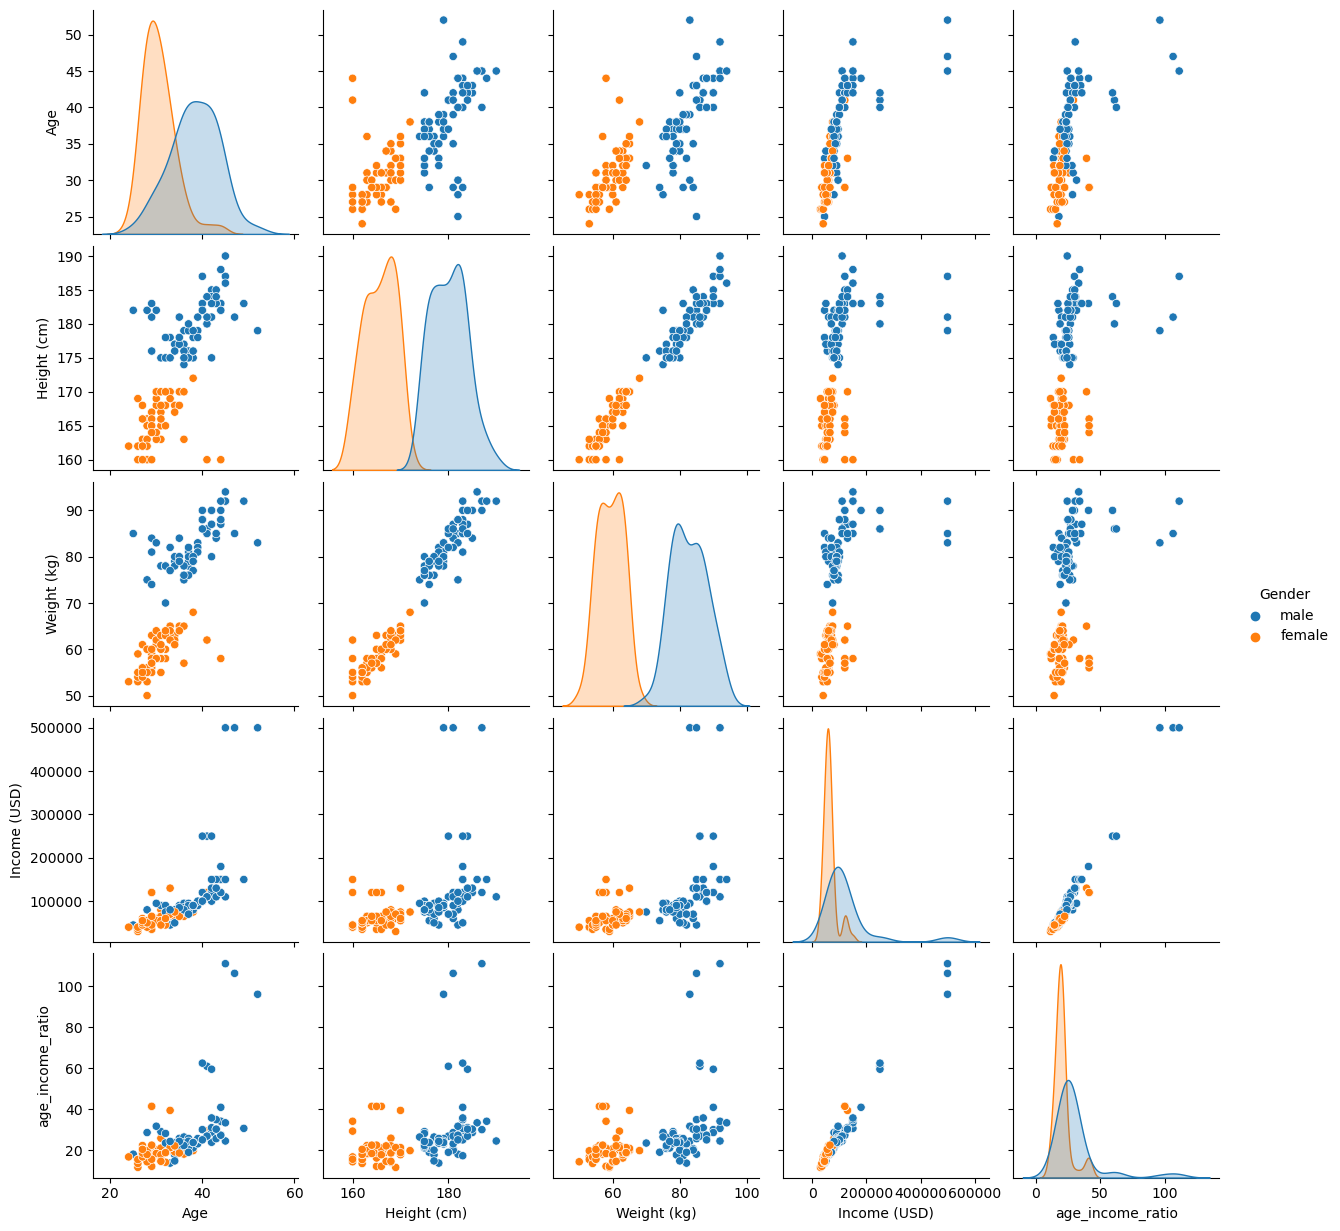

In [53]:
sns.pairplot(df, hue='Gender')

In [54]:
y=df['Gender']
X = df[[x for x in df.columns if x != 'Gender']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
def generate_estimates():
    polys = ['age_income_ratio']
    cat_vars = ['Occupation', 'Education Level', 'Marital Status', 'Favorite Color'  ]
    num_vars = ['Age', 'Height (cm)', 'Weight (kg)', 'Income (USD)']

    poly_pipeline = Pipeline([
        ('add_polynomials', PolynomialFeatures(2, include_bias=False)),
        ('standardize_poly', StandardScaler())])
    
    num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                               ('standardize_num', StandardScaler())
                            ])

    cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                              ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

    processing_pipeline = ColumnTransformer(transformers=[('poly_processing', poly_pipeline, polys),
                                                          ('proc_numeric', num_pipeline, num_vars),
                                                          ('create_dummies', cat_pipeline, cat_vars)])
    modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lr', LogisticRegression())
                             ])
    return modeling_pipeline.fit(X_train, y_train)

m = generate_estimates()

In [56]:
X_test.head()

,Age,Height (cm),Weight (kg),Occupation,Education Level,Marital Status,Income (USD),Favorite Color,age_income_ratio
24,47,181,85,CEO,Doctorate Degree,Married,500000,Blue,106.382979
1,25,182,85,Sales Representative,Bachelor's Degree,Single,45000,Green,18.000000
2,41,160,62,Doctor,Doctorate Degree,Married,120000,Purple,29.268293
38,29,183,81,Sales Representative,Bachelor's Degree,Single,50000,Black,17.241379
73,45,186,94,Lawyer,Master's Degree,Married,150000,Blue,33.333333


In [57]:
y_hat = modeling_pipeline.predict(X_test)

In [58]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        12
        male       1.00      1.00      1.00        15

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



/Users/nehanooka/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/nehanooka/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/nehanooka/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


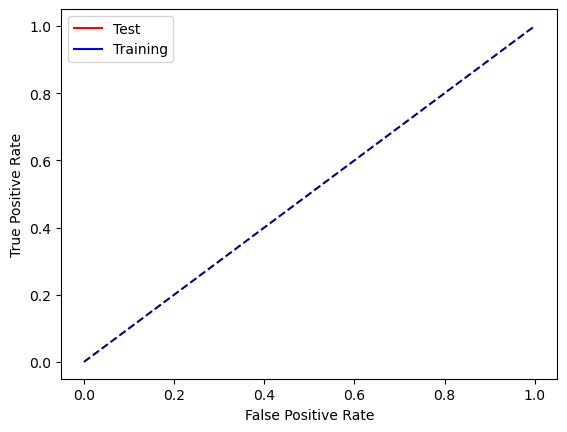

In [59]:
from sklearn.metrics import roc_curve

def generate_probs(X, model=m):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs, pos_label='Yes')
    return fpr, tpr
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [60]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, generate_probs(X_test))

/Users/nehanooka/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


1.0